# Joint analysis of paired and unpaired multiomic data with MultiVI

MultiVI is used for the joint analysis of scRNA and scATAC-seq datasets that were jointly profiled (multiomic / paired) and single-modality datasets (only scRNA or only scATAC). MultiVI uses the paired data as an anchor to align and merge the latent spaces learned from each individual modality.

This tutorial walks through how to read multiomic data, create a joint object with paired and unpaired data, set-up and train a MultiVI model, visualize the resulting latent space, and run differential analyses.

```{note}
Running the following cell will install tutorial dependencies on Google Colab only. It will have no effect on environments other than Google Colab.
```

In [1]:
!pip install --quiet scvi-colab
from scvi_colab import install

install()

/home/olavdc/miniforge3/envs/deeplife/lib/python3.10/site-packages/scvi_colab/_core.py:47: UserWarning: 
                Not currently in Google Colab environment.

                Please run with `run_outside_colab=True` to override.

                Returning with no further action.
                
  warn(


In [2]:
import sys
sys.path.append('/home/olavdc/github/multiVI/scvi_tools/src')

In [3]:
import gzip
import os
import tempfile
from pathlib import Path
import scvi
import matplotlib.pyplot as plt

import numpy as np
import pooch
import scanpy as sc
import scvi_local
import seaborn as sns
import torch

/home/olavdc/miniforge3/envs/deeplife/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# scvi_local.settings.seed = 0
print("Last run with scvi-tools version:", scvi_local.__version__)

Last run with scvi-tools version: 1.2.2.post2


```{note}
You can modify `save_dir` below to change where the data files for this tutorial are saved.
```

In [5]:
sc.set_figure_params(figsize=(6, 6), frameon=False)
sns.set_theme()
torch.set_float32_matmul_precision("high")
save_dir = tempfile.TemporaryDirectory()

%config InlineBackend.print_figure_kwargs={"facecolor": "w"}
%config InlineBackend.figure_format="retina"

## Data acquisition

First we download a sample multiome dataset from 10X. We'll use this throughout this tutorial.
Importantly, MultiVI assumes that there are shared features between the datasets. This is trivial for gene expression datasets, which generally use the same set of genes as features. For ATAC-seq peaks, this is less trivial, and often requires preprocessing steps with other tools to get all datasets to use a shared set of peaks. That can be achieved with tools like SnapATAC, ArchR, and CellRanger in the case of 10X data.

```{important}
MultiVI requires the datasets to use shared features. scATAC-seq datasets need to be processed to use a shared set of peaks.
```

In [6]:
def download_data(save_path: str, fname: str = "pbmc_10k"):
    data_paths = pooch.retrieve(
        url="https://cf.10xgenomics.com/samples/cell-arc/2.0.0/pbmc_unsorted_10k/pbmc_unsorted_10k_filtered_feature_bc_matrix.tar.gz",
        known_hash="872b0dba467d972aa498812a857677ca7cf69050d4f9762b2cd4753b2be694a1",
        fname=fname,
        path=save_path,
        processor=pooch.Untar(),
        progressbar=True,
    )
    data_paths.sort()

    for path in data_paths:
        with gzip.open(path, "rb") as f_in:
            with open(path.replace(".gz", ""), "wb") as f_out:
                f_out.write(f_in.read())

    return str(Path(data_paths[0]).parent)

In [7]:
data_path = download_data(save_dir.name)

100%|████████████████████████████████████████| 375M/375M [00:00<00:00, 472GB/s]
Untarring contents of '/tmp/tmpkr0axrq2/pbmc_10k' to '/tmp/tmpkr0axrq2/pbmc_10k.untar'


## Data Processing

Next, we'll read the data into an Anndata object. We'll then split the data to three datasets, and remove some modality-specific data from parts of the dataset, to demonstrate how MultIVI mixes multimodal and single-modal data.
The data has 12012 cells, we'll use 4004 for each dataset.

Reading the data into an AnnData object can be done with the `read_10x_multiome` function:

In [8]:
# read multiomic data
adata = scvi_local.data.read_10x_multiome(data_path)
adata.var_names_make_unique()

/home/olavdc/miniforge3/envs/deeplife/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


We can now split the dataset to three datasets, and remove a modality from two of them, so we'll have equal-sized (4004 cells in each) datasets with multiome, expression-only, and accessibility-only observations:

In [9]:
# split to three datasets by modality (RNA, ATAC, Multiome), and corrupt data
# by remove some data to create single-modality data
n = 4004
adata_rna = adata[:n, adata.var.modality == "Gene Expression"].copy()
adata_paired = adata[n : 2 * n].copy()
adata_atac = adata[2 * n :, adata.var.modality == "Peaks"].copy()

We can then use the `organize_multiome_anndatas` function to orgnize these three datasets into a single Multiome dataset.
This function sorts and orders the data from the multi-modal and modality-specific AnnDatas into a single AnnData (aligning the features, padding missing modalities with 0s, etc).

In [10]:
# We can now use the organizing method from scvi to concatenate these anndata
adata_mvi = scvi_local.data.organize_multiome_anndatas(adata_paired, adata_rna, adata_atac)

/home/olavdc/github/multiVI/scvi_tools/src/scvi_local/data/_preprocessing.py:334: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  return multi_anndata.concatenate(other, join="outer", batch_key=modality_key)
/home/olavdc/github/multiVI/scvi_tools/src/scvi_local/data/_preprocessing.py:334: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  return multi_anndata.concatenate(other, join="outer", batch_key=modality_key)


Note that `organize_multiome_anndatas` adds an annotation to the cells to indicate which modality they originate from:

In [11]:
adata_mvi.obs

,batch_id,modality
barcode,,
CCGCTAAAGGGCCATC-0-0,1,paired
CCGCTAAAGTCTTGAA-0-0,1,paired
CCGCTAAAGTTAGACC-0-0,1,paired
CCGCTAAAGTTCCCAC-0-0,1,paired
CCGCTAAAGTTTGCGG-0-0,1,paired
...,...,...
TTTGTTGGTACGCGCA-1,1,accessibility
TTTGTTGGTATTTGCC-1,1,accessibility
TTTGTTGGTGATTACG-1,1,accessibility


```{important}
MultiVI requires the features to be ordered so that genes appear before genomic regions. This must be enforced by the user.
```

MultiVI requires the features to be ordered, such that genes appear before genomic regions. In this case this is already the case, but it's always good to verify:

In [12]:
adata_mvi = adata_mvi[:, adata_mvi.var["modality"].argsort()].copy()
adata_mvi.var

,ID,modality,chr,start,end
MIR1302-2HG,ENSG00000243485,Gene Expression,chr1,29553,30267
AL391261.2,ENSG00000258847,Gene Expression,chr14,66004522,66004523
FUT8-AS1,ENSG00000276116,Gene Expression,chr14,65412689,65412690
FUT8,ENSG00000033170,Gene Expression,chr14,65410591,65413008
AL355076.2,ENSG00000258760,Gene Expression,chr14,65302679,65318790
...,...,...,...,...,...
chr15:101277030-101277907,chr15:101277030-101277907,Peaks,chr15,101277030,101277907
chr15:101257856-101258771,chr15:101257856-101258771,Peaks,chr15,101257856,101258771
chr15:101251516-101252373,chr15:101251516-101252373,Peaks,chr15,101251516,101252373
chr15:101397608-101398445,chr15:101397608-101398445,Peaks,chr15,101397608,101398445


We also filter features to remove those that appear in fewer than 1% of the cells

In [13]:
print(adata_mvi.shape)
sc.pp.filter_genes(adata_mvi, min_cells=int(adata_mvi.shape[0] * 0.01))
print(adata_mvi.shape)

(12012, 148458)
(12012, 80878)


## Setup and Training MultiVI

We can now set up and train the MultiVI model!

First, we need to setup the Anndata object using the `setup_anndata` function. At this point we specify any batch annotation that the model would account for.
**Importantly**, the main batch annotation, specific by `batch_key`, should correspond to the modality of the cells.

Other batch annotations (e.g if there are multiple ATAC batches) should be provided using the `categorical_covariate_keys`.

The actual values of categorical covariates (include `batch_key`) are not important, as long as they are different for different samples.
I.e it is not important to call the expression-only samples "expression", as long as they are called something different than the multi-modal and accessibility-only samples.

```{important}
MultiVI requires the main batch annotation to correspond to the modality of the samples. Other batch annotation, such as in the case of multiple RNA-only batches, can be specified using `categorical_covariate_keys`.
```

In [14]:
# Load the autoreload extension
%load_ext autoreload

# Enable automatic reloading of modules
%autoreload 2

In [15]:
scvi_local.model.MULTIVI.setup_anndata(adata_mvi, batch_key="modality")

/tmp/ipykernel_10771/2291870625.py:1: DeprecationWarning: MULTIVI is supposed to work with MuData. the use of anndata is deprecated and will be removed in scvi-tools 1.4. Please use setup_mudata
  scvi_local.model.MULTIVI.setup_anndata(adata_mvi, batch_key="modality")


When creating the object, we need to specify how many of the features are genes, and how many are genomic regions. This is so MultiVI can determine the exact architecture for each modality.

In [16]:
from lightning.pytorch.loggers import WandbLogger
wandb_logger = WandbLogger(project="multiVI-training")

In [17]:
model = scvi_local.model.MULTIVI(
    adata_mvi,
    n_genes=(adata_mvi.var["modality"] == "Gene Expression").sum(),
    n_regions=(adata_mvi.var["modality"] == "Peaks").sum(),
)
# model.view_anndata_setup()


/home/olavdc/miniforge3/envs/deeplife/lib/python3.10/site-packages/torch/nn/init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


In [18]:
model.train(
    logger= wandb_logger,
    log_every_n_steps = 1,
    adversarial_mixing = False)

/tmp/ipykernel_10771/3929091800.py:1: DeprecationWarning: `save_best` is deprecated in v1.2 and will be removed in v1.3. Please use `enable_checkpointing` instead. See https://github.com/scverse/scvi-tools/issues/2568 for more details.
  model.train(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
wandb: Currently logged in as: olav-declerck (deeplife) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/olavdc/miniforge3/envs/deeplife/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/home/olavdc/miniforge3/envs/deeplife/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 252/500:  50%|█████     | 252/500 [21:46<21:25,  5.19s/it, v_num=tzuo, train_loss_step=1.4e+4, train_loss_epoch=1.34e+4] 
Monitored metric reconstruction_loss_validation did not improve in the last 50 records. Best score: 14114.805. Signaling Trainer to stop.


## Save and Load MultiVI models

Saving and loading models is similar to all other scvi-tools models, and is very straight forward:

In [19]:
model_dir = os.path.join(save_dir.name, "multivi_pbmc10k")

model.save(model_dir, overwrite=True)

In [20]:
model = scvi.model.MULTIVI.load(model_dir, adata=adata_mvi)

INFO     File /tmp/tmpkr0axrq2/multivi_pbmc10k/model.pt already downloaded                                         


/home/olavdc/miniforge3/envs/deeplife/lib/python3.10/site-packages/torch/nn/init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


## Extracting and visualizing the latent space

We can now use the `get_latent_representation` to get the latent space from the trained model, and visualize it using scanpy functions:

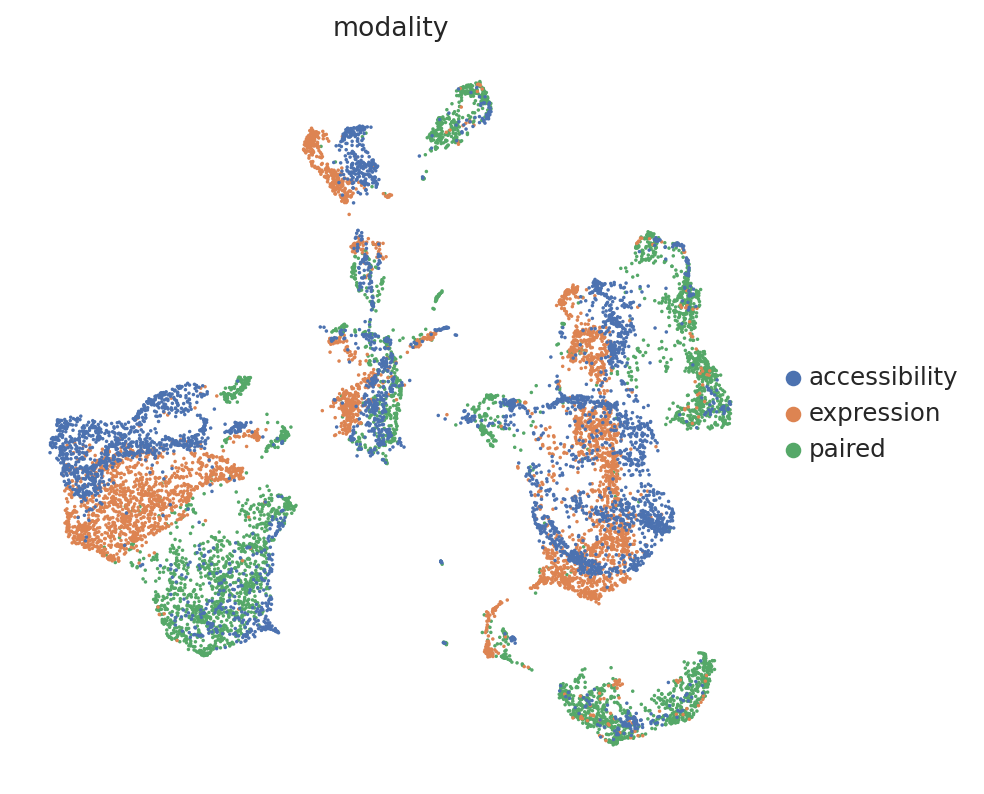

In [21]:
MULTIVI_LATENT_KEY = "X_multivi"

adata_mvi.obsm[MULTIVI_LATENT_KEY] = model.get_latent_representation()
sc.pp.neighbors(adata_mvi, use_rep=MULTIVI_LATENT_KEY)
sc.tl.umap(adata_mvi, min_dist=0.2)
sc.pl.umap(adata_mvi, color="modality")

## Impute missing modalities

In a well-mixed space, MultiVI can seamlessly impute the missing modalities for single-modality cells.
First, imputing expression and accessibility is done with `get_normalized_expression` and `get_accessibility_estimates`, respectively.

We'll demonstrate this by imputing gene expression for all cells in the dataset (including those that are ATAC-only cells):

In [22]:
imputed_expression = model.get_normalized_expression()

We can demonstrate this on some known marker genes:

First, T-cell marker CD3.

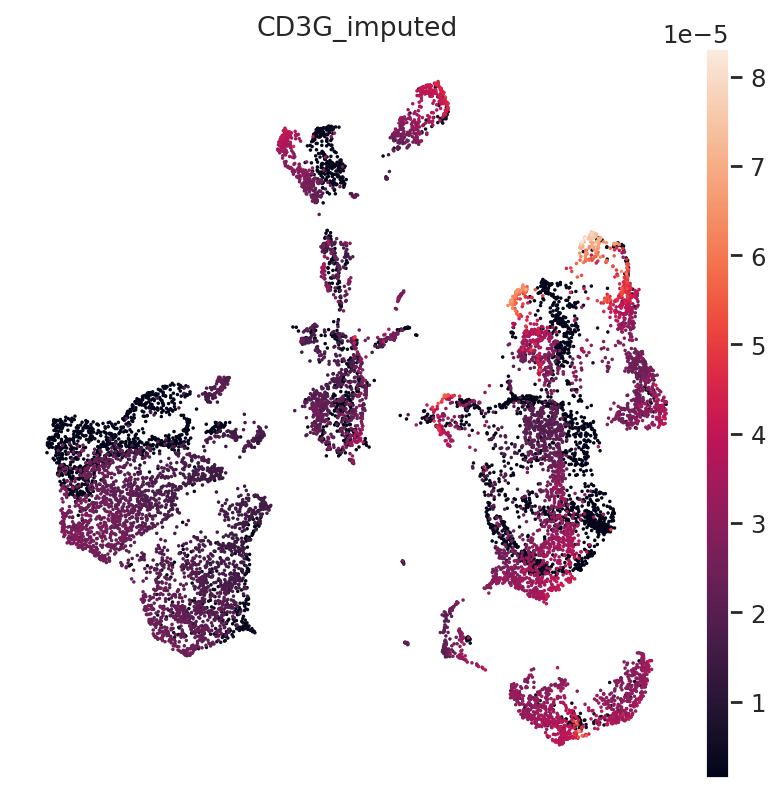

In [23]:
gene_idx = np.where(adata_mvi.var.index == "CD3G")[0]
adata_mvi.obs["CD3G_imputed"] = imputed_expression.iloc[:, gene_idx]
sc.pl.umap(adata_mvi, color="CD3G_imputed")

Next, NK-Cell marker gene NCAM1 (CD56):

In [24]:
gene_idx = np.where(adata_mvi.var.index == "NCAM1")[0]
adata_mvi.obs["NCAM1_imputed"] = imputed_expression.iloc[:, gene_idx]
sc.pl.umap(adata_mvi, color="NCAM1_imputed")

ValueError: Cannot set a DataFrame without columns to the column NCAM1_imputed

Finally, B-Cell Marker CD19:

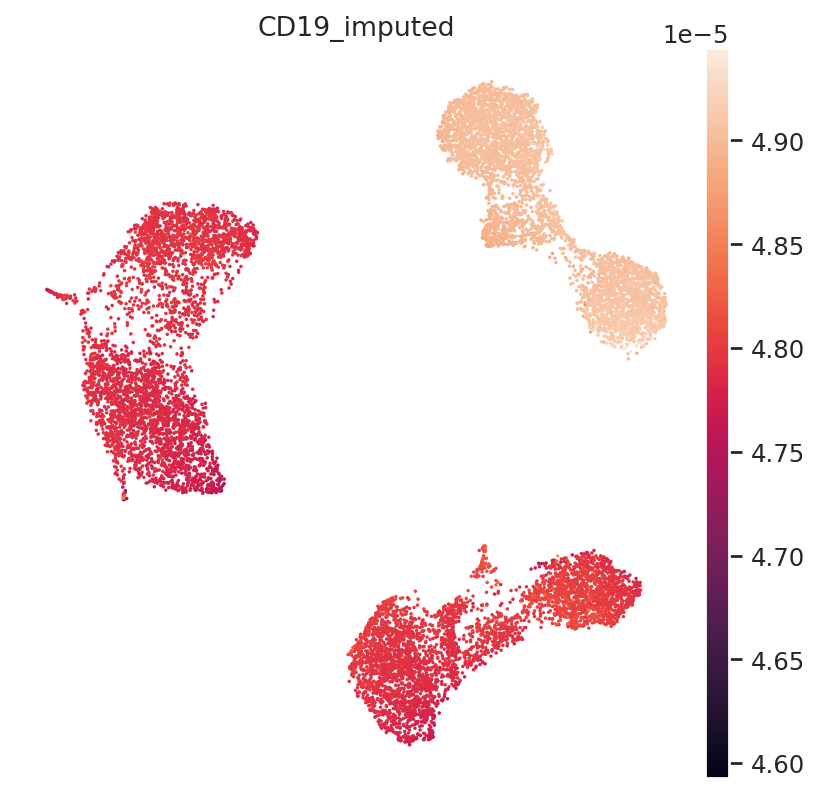

In [ ]:
gene_idx = np.where(adata_mvi.var.index == "CD19")[0]
adata_mvi.obs["CD19_imputed"] = imputed_expression.iloc[:, gene_idx]
sc.pl.umap(adata_mvi, color="CD19_imputed")

All three marker genes clearly identify their respective populations. Importantly, the imputed gene expression profiles are stable and consistent within that population, **even though many of those cells only measured the ATAC profile of those cells**.